# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

In [ ]:
!pip install pandas numpy matplotlib seaborn spacy gensim
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
  A

In [ ]:
!pip install torch torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import tarfile
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import math
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import itertools
%env CUDA_LAUNCH_BLOCKING=1
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from itertools import cycle
import copy

env: CUDA_LAUNCH_BLOCKING=1


## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)
tar_path = 'dbpedia_csv.tar.gz'
extract_dir = 'extracted_data'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

In [ ]:
try:

    with tarfile.open(tar_path, mode='r:gz') as tar:
        tar.extractall(path=extract_dir)

    print("Extraction successful. Files extracted to", extract_dir)
except Exception as e:
    print("An error occurred during extraction:", e)
    raise
print("Extracted files:", os.listdir(extract_dir))

Extraction successful. Files extracted to extracted_data
Extracted files: ['dbpedia_csv']


In [ ]:
train_file = os.path.join(extract_dir, 'dbpedia_csv', 'train.csv')
test_file  = os.path.join(extract_dir, 'dbpedia_csv', 'test.csv')
try:
    train_df = pd.read_csv(train_file, header=None)
    test_df = pd.read_csv(test_file, header=None)
    print("\nTrain and test datasets loaded successfully (without headers).")
except Exception as e:
    print("Error loading CSV files:", e)
    raise


Train and test datasets loaded successfully (without headers).


In [ ]:
column_names = ["output", "word", "description"]
train_df.columns = column_names
test_df.columns = column_names
print("\n--- Train Dataset Preview ---")
print(train_df.head())
print("\n--- Train Dataset Information ---")
print(train_df.info())
print("\n--- Train Dataset Descriptive Statistics ---")
print(train_df.describe(include='all'))
print("\n--- Missing Values in Train Dataset ---")
print(train_df.isnull().sum())


--- Train Dataset Preview ---
   output                               word  \
0       1                   E. D. Abbott Ltd   
1       1                     Schwan-Stabilo   
2       1                         Q-workshop   
3       1  Marvell Software Solutions Israel   
4       1        Bergan Mercy Medical Center   

                                         description  
0   Abbott of Farnham E D Abbott Limited was a Br...  
1   Schwan-STABILO is a German maker of pens for ...  
2   Q-workshop is a Polish company located in Poz...  
3   Marvell Software Solutions Israel known as RA...  
4   Bergan Mercy Medical Center is a hospital loc...  

--- Train Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   output       560000 non-null  int64 
 1   word         560000 non-null  object
 2   description  560000 non-null  ob

In [ ]:
if "description" in train_df.columns:
    train_df['word_count'] = train_df['description'].astype(str).apply(lambda x: len(x.split()))
    print("\nAdded 'word_count' column:")
    print(train_df[['description', 'word_count']].head())
else:
    print("No 'description' column found, please verify the dataset structure.")


Added 'word_count' column:
                                         description  word_count
0   Abbott of Farnham E D Abbott Limited was a Br...          40
1   Schwan-STABILO is a German maker of pens for ...          32
2   Q-workshop is a Polish company located in Poz...          72
3   Marvell Software Solutions Israel known as RA...          29
4   Bergan Mercy Medical Center is a hospital loc...          19


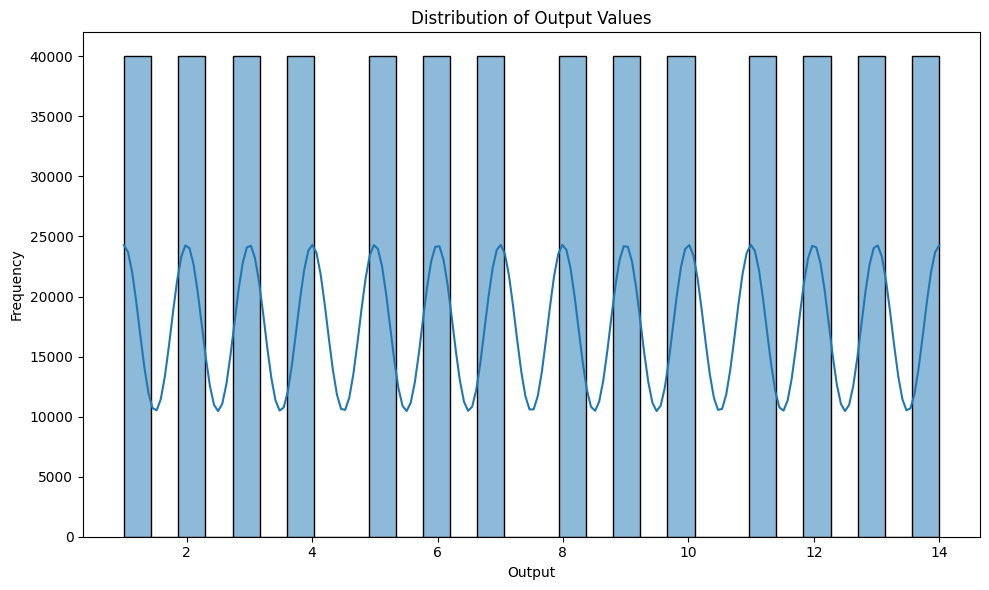

In [ ]:
plt.figure()
sns.histplot(train_df['output'], bins=30, kde=True)
plt.title("Distribution of Output Values")
plt.xlabel("Output")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

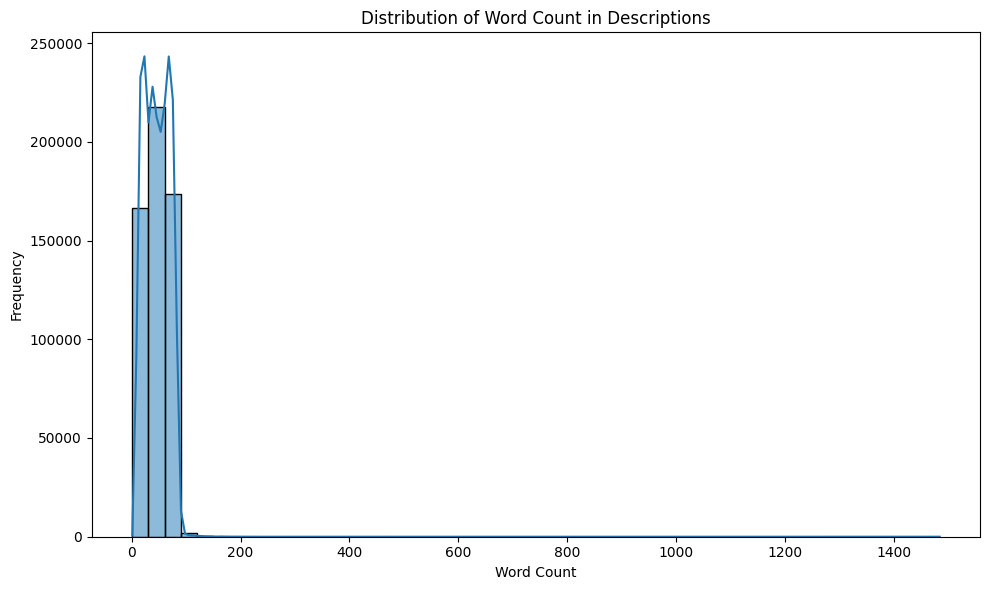

In [ ]:
if 'word_count' in train_df.columns:
    plt.figure()
    sns.histplot(train_df['word_count'], bins=50, kde=True)
    plt.title("Distribution of Word Count in Descriptions")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping word count distribution plot due to missing 'word_count' column.")

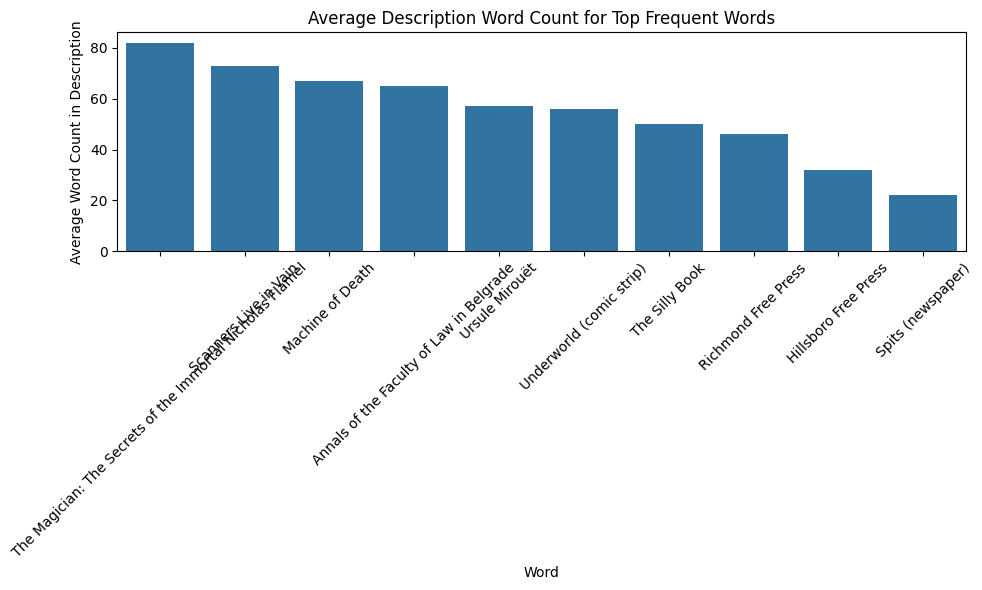

In [ ]:
word_counts = train_df['word'].value_counts().reset_index()
word_counts.columns = ['word', 'frequency']
top_n = 10
top_words = word_counts.head(top_n)['word']
filtered_df = train_df[train_df['word'].isin(top_words)]
agg_stats = filtered_df.groupby('word')['word_count'].mean().reset_index()
agg_stats = agg_stats.merge(word_counts, on='word')
agg_stats = agg_stats.sort_values(by='word_count', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=agg_stats, x='word', y='word_count')
plt.title("Average Description Word Count for Top Frequent Words")
plt.xlabel("Word")
plt.ylabel("Average Word Count in Description")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [ ]:
train_df['output'] = train_df['output'] - 1
test_df['output'] = test_df['output'] - 1
print("Unique labels in train set:", np.unique(train_df['output']))

Unique labels in train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

train_df['cleaned_description'] = train_df['description'].astype(str).apply(clean_text)
test_df['cleaned_description'] = test_df['description'].astype(str).apply(clean_text)
print("Cleaned description in train dataset:")
print(train_df[['description', 'cleaned_description']].head())
print("\nCleaned description in test dataset:")
print(test_df[['description', 'cleaned_description']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaned description in train dataset:
                                         description  \
0   Abbott of Farnham E D Abbott Limited was a Br...   
1   Schwan-STABILO is a German maker of pens for ...   
2   Q-workshop is a Polish company located in Poz...   
3   Marvell Software Solutions Israel known as RA...   
4   Bergan Mercy Medical Center is a hospital loc...   

                                 cleaned_description  
0  abbott farnham e abbott limited british coachb...  
1  schwanstabilo german maker pens writing colour...  
2  qworkshop polish company located poznań specia...  
3  marvell software solutions israel known radlan...  
4  bergan mercy medical center hospital located o...  

Cleaned description in test dataset:
                                         description  \
0   TY KU /taɪkuː/ is an American alcoholic bever...   
1   OddLot Entertainment founded in 2001 by longt...   
2   Henkel AG & Company KGaA operates worldwide w...   
3   The GOAT Store (Games Of All 

In [ ]:
nlp = spacy.blank("en")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return [token.text for token in nlp.tokenizer(text)]

train_df['tokens_custom'] = train_df['cleaned_description'].apply(preprocess)
test_df['tokens_custom'] = test_df['cleaned_description'].apply(preprocess)
print("\nTokenized descriptions using custom preprocessing (train dataset):")
print(train_df[['cleaned_description', 'tokens_custom']].head())


Tokenized descriptions using custom preprocessing (train dataset):
                                 cleaned_description  \
0  abbott farnham e abbott limited british coachb...   
1  schwanstabilo german maker pens writing colour...   
2  qworkshop polish company located poznań specia...   
3  marvell software solutions israel known radlan...   
4  bergan mercy medical center hospital located o...   

                                       tokens_custom  
0  [abbott, farnham, e, abbott, limited, british,...  
1  [schwanstabilo, german, maker, pens, writing, ...  
2  [qworkshop, polish, company, located, pozna, s...  
3  [marvell, software, solutions, israel, known, ...  
4  [bergan, mercy, medical, center, hospital, loc...  


In [ ]:
train_df['tokens_custom'] = train_df['tokens_custom'].apply(lambda tokens: [token for token in tokens if token.strip() != ""])
test_df['tokens_custom'] = test_df['tokens_custom'].apply(lambda tokens: [token for token in tokens if token.strip() != ""])

In [ ]:
all_tokens = train_df['tokens_custom'].tolist() + test_df['tokens_custom'].tolist()
flattened_tokens = [token for tokens in all_tokens for token in tokens]
unique_tokens = sorted(set(flattened_tokens))
print("Vocabulary size:", len(unique_tokens))
print("First 10 tokens in the vocabulary:", unique_tokens[:120])
token_to_index = {token: idx for idx, token in enumerate(unique_tokens)}
print("Token-to-index mapping for first 10 tokens:")

for token in unique_tokens[:10]:
    print(f"{token}: {token_to_index[token]}")

Vocabulary size: 775197
First 10 tokens in the vocabulary: ['a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaad', 'aaadonta', 'aaafnraa', 'aaagh', 'aaahe', 'aaahh', 'aaahydroxyelliptone', 'aaai', 'aaakare', 'aaaklar', 'aaalasgarzade', 'aaalthough', 'aaamemphis', 'aaarrg', 'aaas', 'aaata', 'aaau', 'aaaybelen', 'aaayl', 'aab', 'aaba', 'aabaar', 'aabach', 'aabachstausee', 'aabas', 'aabe', 'aabel', 'aabenraa', 'aaberg', 'aaberge', 'aabhe', 'aabhphs', 'aabida', 'aabk', 'aabo', 'aaboaz', 'aabody', 'aabqal', 'aabra', 'aabroo', 'aabsal', 'aac', 'aacanov', 'aacayipsin', 'aacc', 'aace', 'aach', 'aachariyangal', 'aacharya', 'aachayer', 'aachen', 'aachener', 'aachengermany', 'aachenkornelimnster', 'aachenmnchener', 'aachenosaurus', 'aachi', 'aackolu', 'aacl', 'aaclass', 'aacm', 'aacn', 'aacocrinus', 'aacps', 'aacr', 'aacs', 'aacsb', 'aacsbaccredited', 'aacsbcitation', 'aacsengleside', 'aacta', 'aacu', 'aad', 'aada', 'aadahl', 'aadalat', 'aadalca', 'aadam', 'aadaminte', 'aadamkhor', 'aadan', 'aadanthe', 'aada

## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [ ]:
all_token_lists = train_df['tokens_custom'].tolist() + test_df['tokens_custom'].tolist()
w2v_model = Word2Vec(sentences=all_token_lists, vector_size=100, window=5, min_count=1, workers=4)
example_token = "data"
if example_token in w2v_model.wv:
    embedding = w2v_model.wv[example_token]
    print(f"Embedding for '{example_token}':\n", embedding)
else:
    print(f"Token '{example_token}' not found in the vocabulary.")

def document_vector(token_list, model):
    valid_tokens = [token for token in token_list if token in model.wv]
    if valid_tokens:
        return np.mean([model.wv[token] for token in valid_tokens], axis=0)
    else:
        return np.zeros(model.vector_size)

train_df['doc_vector'] = train_df['tokens_custom'].apply(lambda tokens: document_vector(tokens, w2v_model))
test_df['doc_vector']  = test_df['tokens_custom'].apply(lambda tokens: document_vector(tokens, w2v_model))
print("\nExample document vector from train_df:")
print(train_df[['cleaned_description', 'doc_vector']].head())

Embedding for 'data':
 [ 0.18608424 -0.8841035  -0.8298563   0.5993026  -1.6425185  -1.8403276
 -2.7893713   1.7245754   2.5203254   1.0012667  -1.5383459  -2.3863103
 -2.3497112  -2.6198244  -0.54025257 -0.971641   -0.29607993  1.7642556
 -0.22906902 -2.4372866   2.5762274  -0.9864856   0.9253148   2.372821
 -0.39549702 -0.17844234 -0.98043656  0.69504887  3.3650417   1.9344505
 -0.2771072  -0.14903148 -2.9402878  -3.2464292   0.59425014  1.9168704
  1.1595988   0.7737928   1.1606464   0.00625217  2.0343463   1.8506534
 -2.2560701  -0.67257273  2.5978065  -1.0810038  -0.097007   -0.1111728
  4.867886    0.36824656  1.7380897   0.7046483  -1.7657462  -0.25073016
 -0.7450061  -0.38974392  0.6653073  -1.4997929  -0.966246    0.7394872
 -1.3262858   0.27538192  0.7930043   0.38968423 -2.9457598   0.43122303
 -2.4997365  -3.5135803  -0.98706776  1.9499444  -2.4718688   0.22358118
 -2.2758222  -1.490719   -2.0404713   0.733475   -0.42503703 -1.990496
 -2.9095335  -2.781126    2.5555398  -0.

In [ ]:
all_tokens = train_df['tokens_custom'].tolist() + test_df['tokens_custom'].tolist()
unique_tokens = sorted(set(token for tokens in all_tokens for token in tokens))
print("Vocabulary size:", len(unique_tokens))
print("First 10 tokens in the vocabulary:", unique_tokens[:10])
token_to_index = {token: idx + 2 for idx, token in enumerate(unique_tokens)}
token_to_index["<PAD>"] = 0
token_to_index["<UNK>"] = 1
index_to_token = {idx: token for token, idx in token_to_index.items()}

Vocabulary size: 775197
First 10 tokens in the vocabulary: ['a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaad', 'aaadonta', 'aaafnraa', 'aaagh', 'aaahe']


In [ ]:
def tokens_to_ids(token_list, mapping, unk_id=token_to_index["<UNK>"]):
    return [mapping.get(token, unk_id) for token in token_list]

train_df['token_ids'] = train_df['tokens_custom'].apply(lambda tokens: tokens_to_ids(tokens, token_to_index))
test_df['token_ids'] = test_df['tokens_custom'].apply(lambda tokens: tokens_to_ids(tokens, token_to_index))

In [ ]:
max_seq_len = 50

def pad_sequence(seq, max_len, pad_id=token_to_index["<PAD>"]):
    if len(seq) < max_len:
        return seq + [pad_id] * (max_len - len(seq))
    else:
        return seq[:max_len]

train_df['token_ids'] = train_df['token_ids'].apply(lambda seq: pad_sequence(seq, max_seq_len))
test_df['token_ids'] = test_df['token_ids'].apply(lambda seq: pad_sequence(seq, max_seq_len))
print("Example token_ids from train_df:")
print(train_df[['tokens_custom', 'token_ids']].head())

Example token_ids from train_df:
                                       tokens_custom  \
0  [abbott, farnham, e, abbott, limited, british,...   
1  [schwanstabilo, german, maker, pens, writing, ...   
2  [qworkshop, polish, company, located, pozna, s...   
3  [marvell, software, solutions, israel, known, ...   
4  [bergan, mercy, medical, center, hospital, loc...   

                                           token_ids  
0  [1077, 221892, 194909, 1077, 391277, 92165, 13...  
1  [607084, 252560, 410781, 518328, 756616, 13911...  
2  [559271, 535490, 140968, 396053, 541081, 64479...  
3  [419914, 639179, 640390, 321525, 359884, 56057...  
4  [68957, 431731, 427583, 115265, 299397, 396053...  


2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [ ]:
import torch
import torch.nn as nn
import math
from torchinfo import summary

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1, max_seq_len=50):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token_to_index["<PAD>"])
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, src, src_key_padding_mask=None):
        x = self.embedding(src)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x.mean(dim=0)
        x = self.dropout(x)
        out = self.fc(x)
        return out

4.	Print model summary using torchinfo.summary

In [ ]:
vocab_size = len(token_to_index)
embed_dim = 100
num_classes = len(train_df['output'].unique())
num_layers = 2
nhead = 4
hidden_dim = 128
dropout = 0.1
max_seq_len = 50
model = TransformerClassifier(vocab_size, embed_dim, num_classes, num_layers, nhead, hidden_dim, dropout, max_seq_len)
dummy_input = torch.randint(0, vocab_size, (8, max_seq_len), dtype=torch.long)
print(summary(model, input_data=dummy_input))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [8, 14]                   --
├─Embedding: 1-1                              [8, 50, 100]              77,519,900
├─PositionalEncoding: 1-2                     [8, 50, 100]              --
│    └─Dropout: 2-1                           [8, 50, 100]              --
├─TransformerEncoder: 1-3                     [50, 8, 100]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [50, 8, 100]              66,628
│    │    └─TransformerEncoderLayer: 3-2      [50, 8, 100]              66,628
├─Dropout: 1-4                                [8, 100]                  --
├─Linear: 1-5                                 [8, 14]                   1,414
Total params: 77,654,570
Trainable params: 77,654,570
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 622.79
Input size (MB): 0.00
Forward/b

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


5. Briefly describe the Transformer architecture you have defined.

The Transformer is a deep learning architecture designed to process entire sequences of data in parallel, rather than step by step as in recurrent networks. At its heart lies the self‑attention mechanism, which allows each element of the sequence to weigh the importance of every other element when building its representation. This means that, for example, a word in a sentence can directly “attend” to another word several positions away, capturing long‑range dependencies with ease.

Because self‑attention itself doesn’t encode any information about the order of the sequence, the Transformer adds positional encodings to the token embeddings. In your implementation, sinusoidal functions of different frequencies are precomputed and added to the embeddings, ensuring that the model can distinguish “first” from “last” and everything in between. This simple addition reintroduces sequence order without sacrificing the parallelism that makes Transformers so efficient.

Each Transformer encoder layer is composed of two main sub‑layers, each wrapped with a residual connection and followed by layer normalization. First comes multi‑head self‑attention, where the embedding is split into several “heads” (four in your case), each learning to focus on different aspects of the sequence simultaneously. The outputs of these heads are concatenated and linearly projected back to the original embedding dimension. Next is the position‑wise feed‑forward network, a small two‑layer MLP (with hidden size 128 here) that is applied independently to each position. These residual connections help gradients flow more easily during training and stabilize deep models.

By stacking multiple such encoder layers (two in your classifier), the model gradually refines its understanding of the sequence: early layers capture local patterns and relationships, while deeper layers synthesize more abstract, global information. Once the input has passed through all encoder layers, you collapse the time dimension by averaging across all token positions, yielding a single fixed‑length vector per example.

Finally, a dropout layer helps guard against overfitting, and a simple linear layer maps that pooled vector to the desired number of output classes. In this way, the TransformerClassifier combines the parallel, flexible modeling of attention with straightforward pooling and classification, making it both powerful and easy to scale.

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [ ]:
X = np.stack(train_df['token_ids'].values)
y = train_df['output'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on:", device)
vocab_size = len(token_to_index)
embed_dim = 100
num_classes = len(train_df['output'].unique())
num_layers = 2
nhead = 4
hidden_dim = 128
dropout = 0.1
max_seq_len = 50
model = TransformerClassifier(vocab_size, embed_dim, num_classes, num_layers, nhead, hidden_dim, dropout, max_seq_len)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

Training on: cuda


2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [ ]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        src_key_padding_mask = (inputs == token_to_index["<PAD>"])
        optimizer.zero_grad()
        outputs = model(inputs, src_key_padding_mask=src_key_padding_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():

        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            src_key_padding_mask = (inputs == token_to_index["<PAD>"])
            outputs = model(inputs, src_key_padding_mask=src_key_padding_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


Epoch 1/10 | Train Loss: 2.6285, Train Acc: 0.1069 | Val Loss: 2.5373, Val Acc: 0.2074
Epoch 2/10 | Train Loss: 2.4586, Train Acc: 0.2489 | Val Loss: 2.2927, Val Acc: 0.3913
Epoch 3/10 | Train Loss: 2.1457, Train Acc: 0.4140 | Val Loss: 1.8685, Val Acc: 0.5042
Epoch 4/10 | Train Loss: 1.7587, Train Acc: 0.5075 | Val Loss: 1.5155, Val Acc: 0.5694
Epoch 5/10 | Train Loss: 1.4810, Train Acc: 0.5686 | Val Loss: 1.3008, Val Acc: 0.6253
Epoch 6/10 | Train Loss: 1.2935, Train Acc: 0.6187 | Val Loss: 1.1389, Val Acc: 0.6597
Epoch 7/10 | Train Loss: 1.1523, Train Acc: 0.6592 | Val Loss: 1.0117, Val Acc: 0.7016
Epoch 8/10 | Train Loss: 1.0380, Train Acc: 0.6991 | Val Loss: 0.9011, Val Acc: 0.7406
Epoch 9/10 | Train Loss: 0.9389, Train Acc: 0.7328 | Val Loss: 0.8083, Val Acc: 0.7646
Epoch 10/10 | Train Loss: 0.8568, Train Acc: 0.7538 | Val Loss: 0.7379, Val Acc: 0.7802


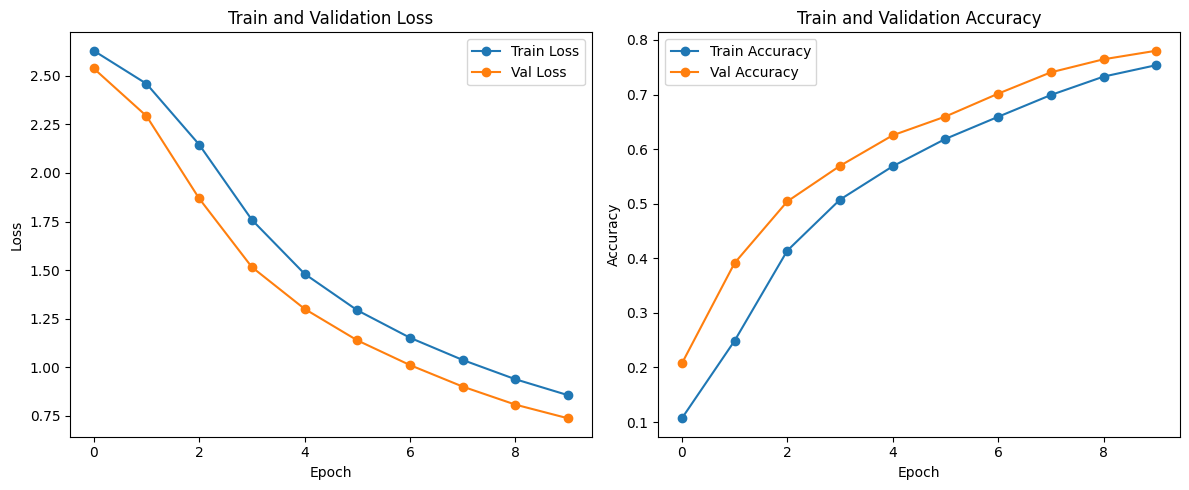

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X_test = np.stack(test_df['token_ids'].values)
y_test = test_df['output'].values
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on:", device)

Training on: cuda


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():

        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            src_key_padding_mask = (inputs == token_to_index["<PAD>"])
            outputs = model(inputs, src_key_padding_mask=src_key_padding_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return avg_loss, acc, precision, recall, f1, np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_roc_curve(y_true, y_probs, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()

Baseline Test Metrics:
Loss: 0.7487, Acc: 0.7758
Precision: 0.7781, Recall: 0.7758, F1: 0.7729


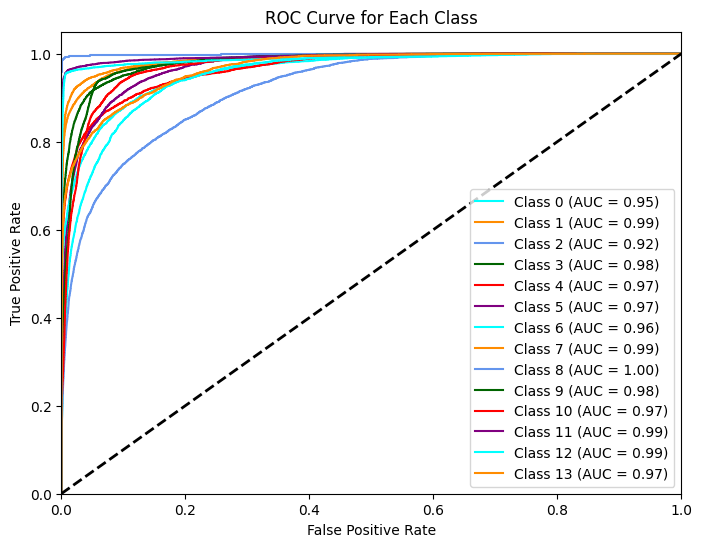

Baseline model weights saved as 'baseline_transformer_model.pt'.


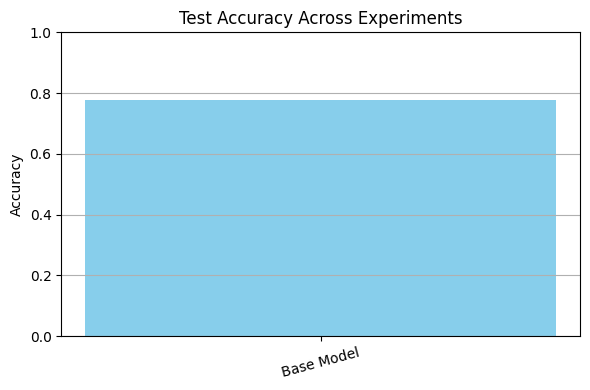

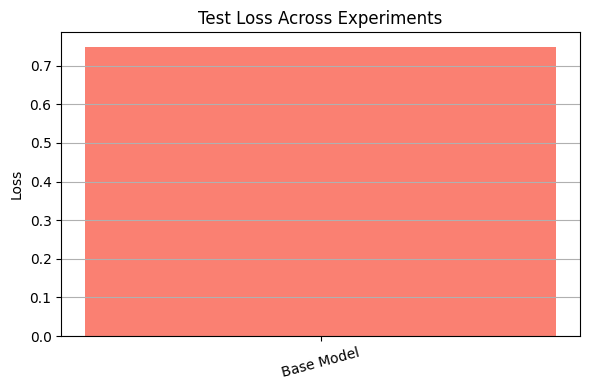

In [ ]:
baseline_test_metrics = evaluate_model(model, test_loader)
print("Baseline Test Metrics:")
print(f"Loss: {baseline_test_metrics[0]:.4f}, Acc: {baseline_test_metrics[1]:.4f}")
print(f"Precision: {baseline_test_metrics[2]:.4f}, Recall: {baseline_test_metrics[3]:.4f}, F1: {baseline_test_metrics[4]:.4f}")
plot_roc_curve(baseline_test_metrics[5], baseline_test_metrics[7], n_classes=len(train_df['output'].unique()))
torch.save(model.state_dict(), "baseline_transformer_model.pt")
print("Baseline model weights saved as 'baseline_transformer_model.pt'.")
plt.figure(figsize=(6,4))
plt.bar("Base Model", baseline_test_metrics[1], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Across Experiments')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.bar('Base Model', baseline_test_metrics[0], color='salmon')
plt.ylabel('Loss')
plt.title('Test Loss Across Experiments')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

### Weight decay:

In [ ]:
num_epochs = 10

def train_model(model, optimizer, num_epochs, train_loader, val_loader, early_stopping_patience=None):
    criterion = nn.CrossEntropyLoss()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            src_key_padding_mask = (inputs == token_to_index["<PAD>"])
            optimizer.zero_grad()
            outputs = model(inputs, src_key_padding_mask=src_key_padding_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_loss, val_acc, _, _, _, _, _, _ = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if early_stopping_patience is not None and epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_l2 = TransformerClassifier(len(token_to_index), 100, len(train_df['output'].unique()),
                                 num_layers=2, nhead=4, hidden_dim=128, dropout=0.0, max_seq_len=50)
model_l2 = model_l2.to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=1e-6, weight_decay=1e-4)
model_l2, l2_history = train_model(model_l2, optimizer_l2, num_epochs, train_loader, val_loader)

Epoch 1/10 | Train Loss: 2.5905, Acc: 0.1434 | Val Loss: 2.5098, Acc: 0.2629
Epoch 2/10 | Train Loss: 2.3734, Acc: 0.3336 | Val Loss: 2.1957, Acc: 0.3968
Epoch 3/10 | Train Loss: 1.9820, Acc: 0.4395 | Val Loss: 1.7745, Acc: 0.4853
Epoch 4/10 | Train Loss: 1.5989, Acc: 0.5321 | Val Loss: 1.4380, Acc: 0.5696
Epoch 5/10 | Train Loss: 1.3198, Acc: 0.6013 | Val Loss: 1.2160, Acc: 0.6309
Epoch 6/10 | Train Loss: 1.1412, Acc: 0.6519 | Val Loss: 1.0701, Acc: 0.6716
Epoch 7/10 | Train Loss: 1.0116, Acc: 0.6891 | Val Loss: 0.9531, Acc: 0.7071
Epoch 8/10 | Train Loss: 0.9055, Acc: 0.7222 | Val Loss: 0.8586, Acc: 0.7391
Epoch 9/10 | Train Loss: 0.8205, Acc: 0.7528 | Val Loss: 0.7820, Acc: 0.7660
Epoch 10/10 | Train Loss: 0.7513, Acc: 0.7738 | Val Loss: 0.7204, Acc: 0.7825


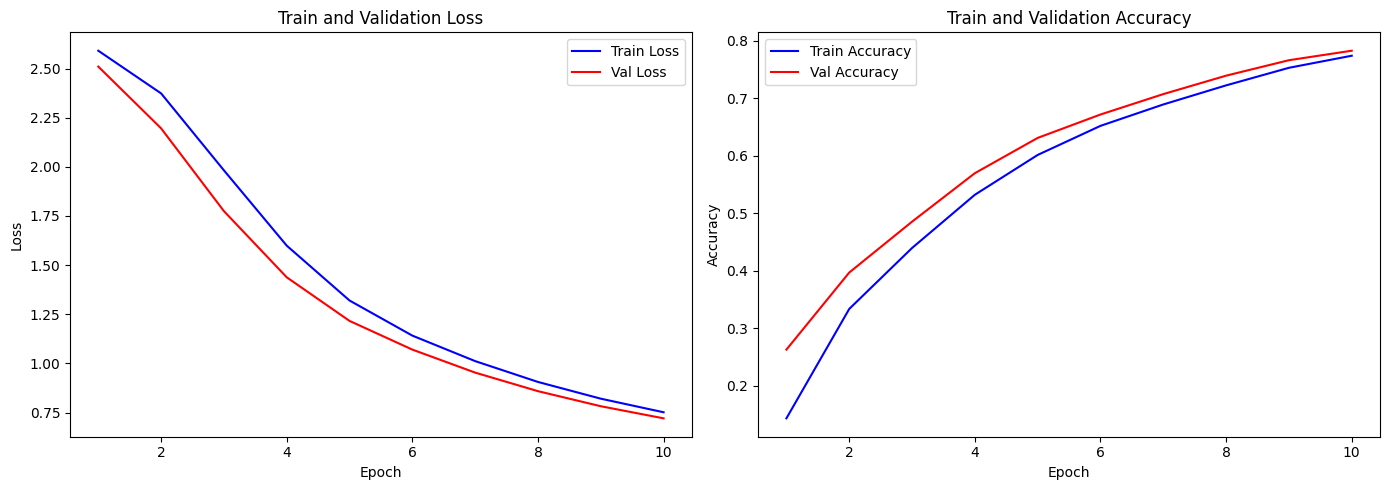

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, l2_history[0], 'b-', label='Train Loss')
plt.plot(epochs, l2_history[1],   'r-', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, l2_history[2], 'b-', label='Train Accuracy')
plt.plot(epochs, l2_history[3],   'r-', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

L2 Regularization Test Metrics:
Loss: 0.7223, Acc: 0.7805
Precision: 0.7821, Recall: 0.7805, F1: 0.7780


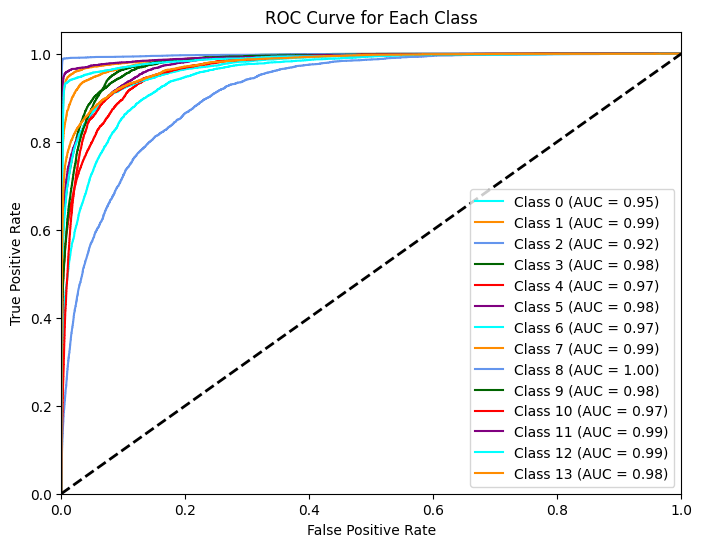

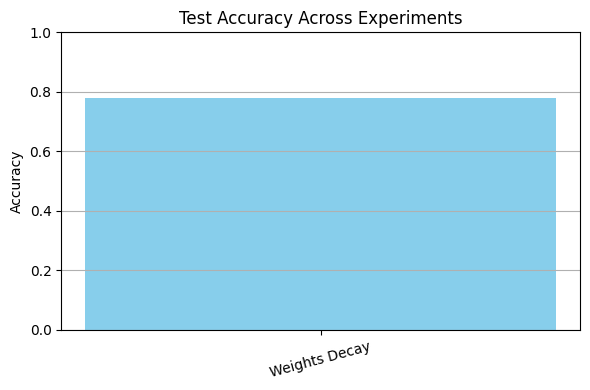

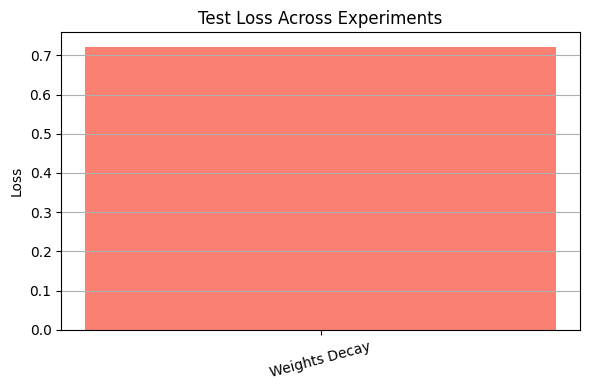

In [ ]:
l2_test_metrics = evaluate_model(model_l2, test_loader)
print("L2 Regularization Test Metrics:")
print(f"Loss: {l2_test_metrics[0]:.4f}, Acc: {l2_test_metrics[1]:.4f}")
print(f"Precision: {l2_test_metrics[2]:.4f}, Recall: {l2_test_metrics[3]:.4f}, F1: {l2_test_metrics[4]:.4f}")
plot_roc_curve(l2_test_metrics[5], l2_test_metrics[7], n_classes=len(train_df['output'].unique()))
plt.figure(figsize=(6,4))
plt.bar("Weights Decay", l2_test_metrics[1], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Across Experiments')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.bar('Weights Decay', l2_test_metrics[0], color='salmon')
plt.ylabel('Loss')
plt.title('Test Loss Across Experiments')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Early stopping:

In [ ]:
model_es = TransformerClassifier(len(token_to_index), 100, len(train_df['output'].unique()),
                                 num_layers=2, nhead=4, hidden_dim=128, dropout=0.0, max_seq_len=50)
model_es = model_es.to(device)
optimizer_es = optim.Adam(model_es.parameters(), lr=1e-5)
model_es, es_history = train_model(model_es, optimizer_es, num_epochs, train_loader, val_loader, early_stopping_patience=3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 | Train Loss: 1.3020, Acc: 0.6275 | Val Loss: 0.6257, Acc: 0.8169
Epoch 2/10 | Train Loss: 0.5003, Acc: 0.8519 | Val Loss: 0.4182, Acc: 0.8745
Epoch 3/10 | Train Loss: 0.3726, Acc: 0.8899 | Val Loss: 0.3396, Acc: 0.8987
Epoch 4/10 | Train Loss: 0.3119, Acc: 0.9074 | Val Loss: 0.2946, Acc: 0.9124
Epoch 5/10 | Train Loss: 0.2728, Acc: 0.9190 | Val Loss: 0.2632, Acc: 0.9216
Epoch 6/10 | Train Loss: 0.2447, Acc: 0.9275 | Val Loss: 0.2407, Acc: 0.9281
Epoch 7/10 | Train Loss: 0.2232, Acc: 0.9341 | Val Loss: 0.2225, Acc: 0.9337
Epoch 8/10 | Train Loss: 0.2063, Acc: 0.9389 | Val Loss: 0.2079, Acc: 0.9382
Epoch 9/10 | Train Loss: 0.1922, Acc: 0.9433 | Val Loss: 0.1962, Acc: 0.9423
Epoch 10/10 | Train Loss: 0.1803, Acc: 0.9469 | Val Loss: 0.1860, Acc: 0.9451


b. Plot the training and validation accuracy over time (epochs).

   c. Plot the training and validation loss over time (epochs).


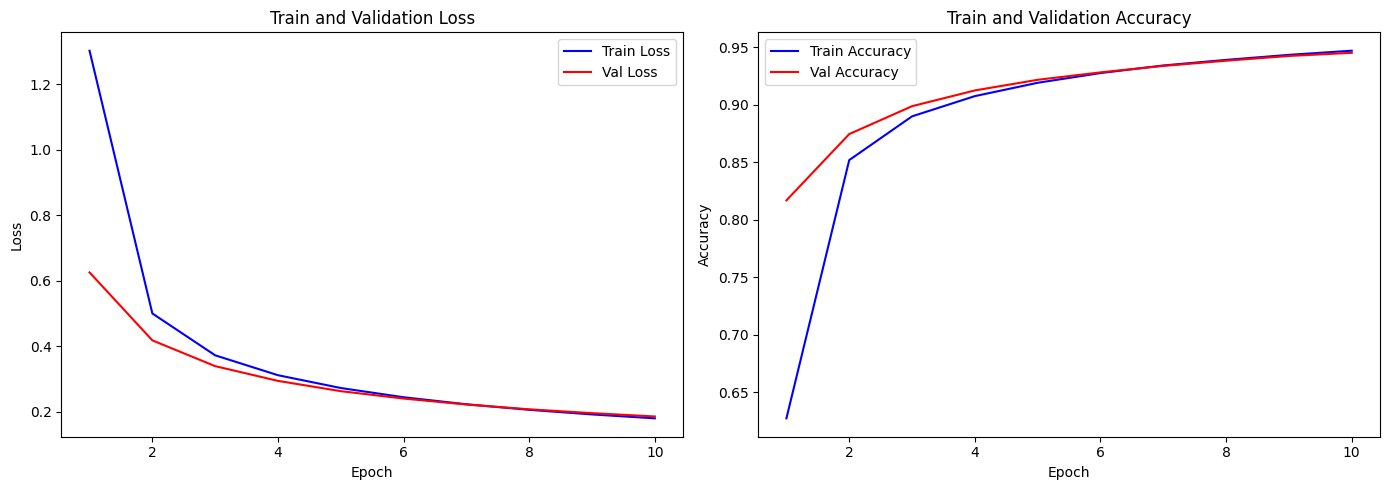

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, es_history[0], 'b-', label='Train Loss')
plt.plot(epochs, es_history[1],   'r-', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, es_history[2], 'b-', label='Train Accuracy')
plt.plot(epochs, es_history[3],   'r-', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


   e. Plot the ROC curve.

Early Stopping Test Metrics:
Loss: 0.1870, Acc: 0.9453
Precision: 0.9453, Recall: 0.9453, F1: 0.9453


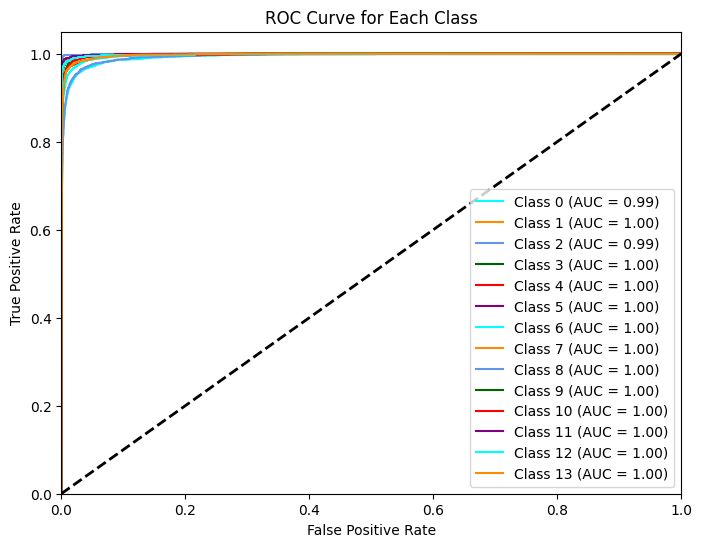

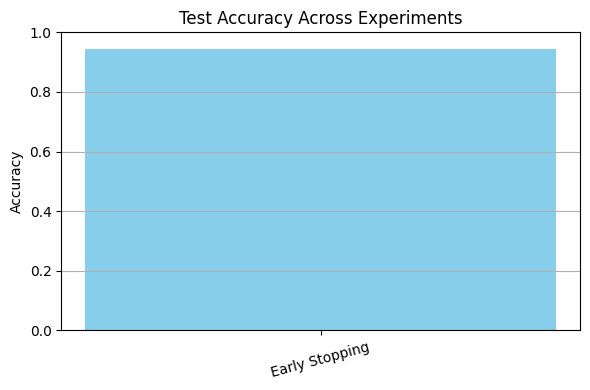

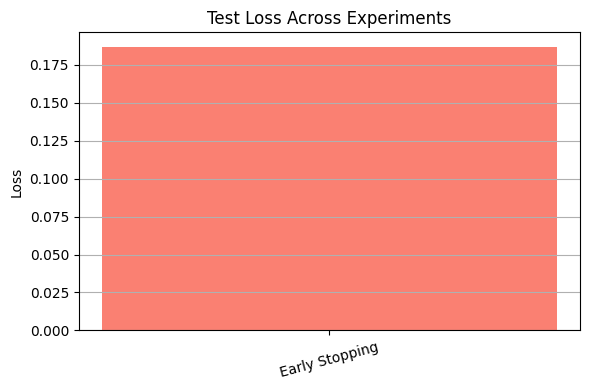

In [ ]:
es_test_metrics = evaluate_model(model_es, test_loader)
print("Early Stopping Test Metrics:")
print(f"Loss: {es_test_metrics[0]:.4f}, Acc: {es_test_metrics[1]:.4f}")
print(f"Precision: {es_test_metrics[2]:.4f}, Recall: {es_test_metrics[3]:.4f}, F1: {es_test_metrics[4]:.4f}")
plot_roc_curve(es_test_metrics[5], es_test_metrics[7], n_classes=len(train_df['output'].unique()))
plt.figure(figsize=(6,4))
plt.bar("Early Stopping", es_test_metrics[1], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Across Experiments')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.bar('Early Stopping', es_test_metrics[0], color='salmon')
plt.ylabel('Loss')
plt.title('Test Loss Across Experiments')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### LR Scheduler:

In [ ]:
print("\n--- Experiment 3: Learning Rate Tuning with Scheduler ---")
model_lr = TransformerClassifier(len(token_to_index), 100, len(train_df['output'].unique()),
                                 num_layers=2, nhead=4, hidden_dim=128, dropout=0.0, max_seq_len=50)
model_lr = model_lr.to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lr, mode='min', factor=0.5, patience=2, verbose=True)


--- Experiment 3: Learning Rate Tuning with Scheduler ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_model_with_scheduler(model, optimizer, scheduler, num_epochs, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            src_key_padding_mask = (inputs == token_to_index["<PAD>"])
            optimizer.zero_grad()
            outputs = model(inputs, src_key_padding_mask=src_key_padding_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_loss, val_acc, _, _, _, _, _, _ = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, (train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
model_lr, lr_history = train_model_with_scheduler(model_lr, optimizer_lr, scheduler, num_epochs, train_loader, val_loader)

Epoch 1/10 | Train Loss: 2.5904, Acc: 0.1756 | Val Loss: 2.4998, Acc: 0.2955
Epoch 2/10 | Train Loss: 2.3288, Acc: 0.3884 | Val Loss: 2.1041, Acc: 0.4631
Epoch 3/10 | Train Loss: 1.8597, Acc: 0.5035 | Val Loss: 1.6395, Acc: 0.5313
Epoch 4/10 | Train Loss: 1.4906, Acc: 0.5580 | Val Loss: 1.3735, Acc: 0.5779
Epoch 5/10 | Train Loss: 1.2960, Acc: 0.6095 | Val Loss: 1.2233, Acc: 0.6387
Epoch 6/10 | Train Loss: 1.1593, Acc: 0.6665 | Val Loss: 1.0925, Acc: 0.6909
Epoch 7/10 | Train Loss: 1.0318, Acc: 0.7104 | Val Loss: 0.9685, Acc: 0.7291
Epoch 8/10 | Train Loss: 0.9148, Acc: 0.7406 | Val Loss: 0.8627, Acc: 0.7520
Epoch 9/10 | Train Loss: 0.8220, Acc: 0.7614 | Val Loss: 0.7839, Acc: 0.7701
Epoch 10/10 | Train Loss: 0.7530, Acc: 0.7788 | Val Loss: 0.7241, Acc: 0.7853


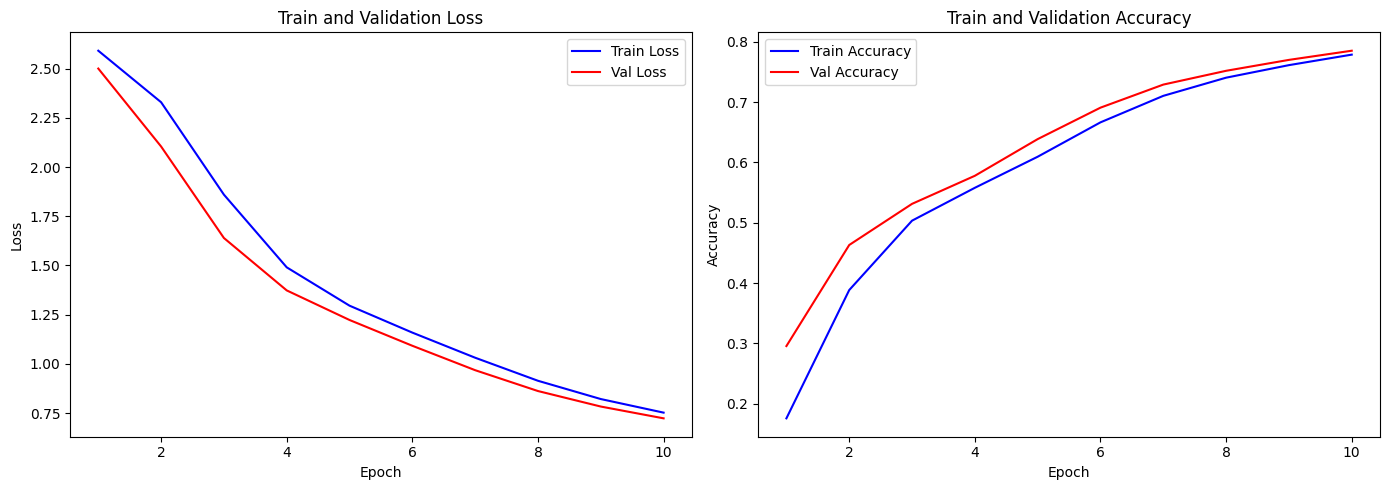

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, lr_history[0], 'b-', label='Train Loss')
plt.plot(epochs, lr_history[1],   'r-', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, lr_history[2], 'b-', label='Train Accuracy')
plt.plot(epochs, lr_history[3],   'r-', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

Learning Rate Scheduler Test Metrics:
Loss: 0.7278, Acc: 0.7862
Precision: 0.7914, Recall: 0.7862, F1: 0.7872


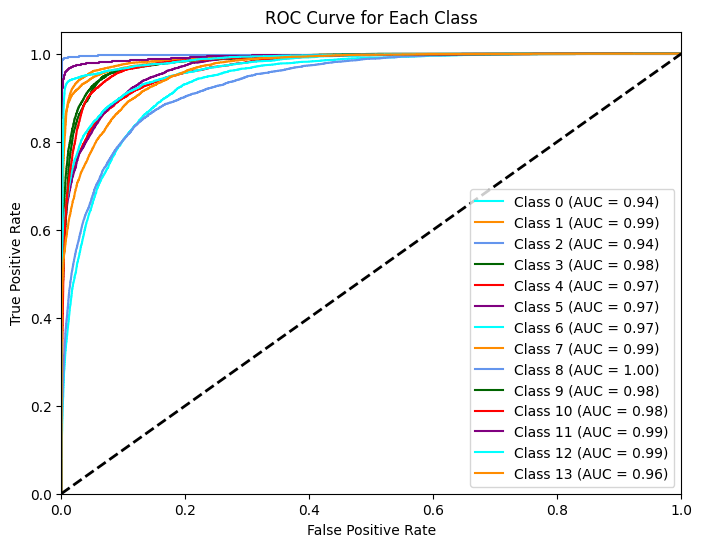

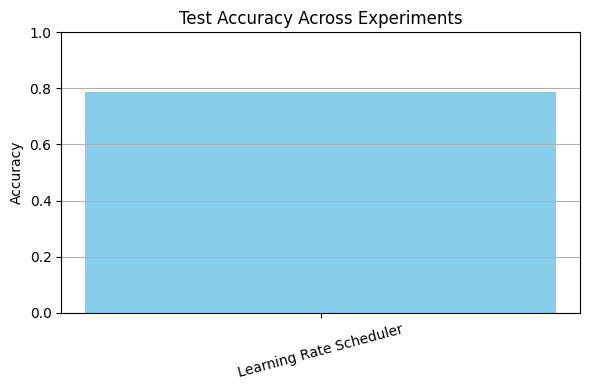

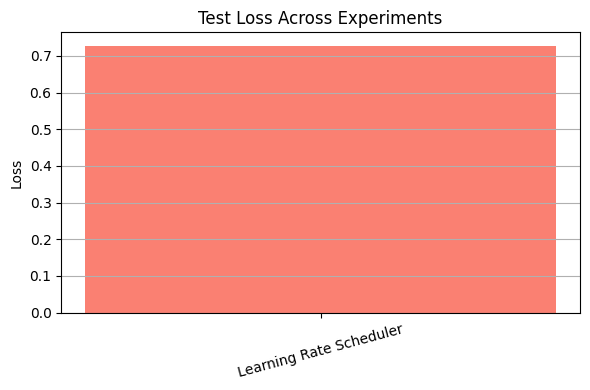

In [ ]:
lr_test_metrics = evaluate_model(model_lr, test_loader)
print("Learning Rate Scheduler Test Metrics:")
print(f"Loss: {lr_test_metrics[0]:.4f}, Acc: {lr_test_metrics[1]:.4f}")
print(f"Precision: {lr_test_metrics[2]:.4f}, Recall: {lr_test_metrics[3]:.4f}, F1: {lr_test_metrics[4]:.4f}")
plot_roc_curve(lr_test_metrics[5], lr_test_metrics[7], n_classes=len(train_df['output'].unique()))
plt.figure(figsize=(6,4))
plt.bar("Learning Rate Scheduler", lr_test_metrics[1], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Across Experiments')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.bar('Learning Rate Scheduler', lr_test_metrics[0], color='salmon')
plt.ylabel('Loss')
plt.title('Test Loss Across Experiments')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

2. Discuss how the optimization techniques helped to improve the performance of the model.

In my experiments with Transformer optimization, I started with a solid baseline model that achieved around 77.6% accuracy. While this was a good starting point, I wanted to see how different optimization techniques could help improve both performance and generalization. By introducing regularization, adjusting the learning rate, and incorporating scheduling strategies, I was able to steadily enhance the model's results.

First, I applied weight decay (L2 regularization) to reduce the chances of overfitting. This technique lightly penalizes large weights, encouraging the model to find simpler, more generalizable patterns. After applying it, I saw a slight improvement—test loss dropped from 0.7487 to 0.7223, and accuracy rose to 78.05%. The increase in precision and F1 score, though modest, suggested that the model’s predictions had become more consistent and reliable.

Next, I experimented with a smaller learning rate, reducing it from 1e‑4 to 1e‑5. Although I had early stopping set up, it didn’t activate—yet the smaller learning rate alone made a significant difference. The model converged more smoothly, and the performance jumped dramatically: test loss dropped to 0.1870, and accuracy, precision, recall, and F1 all reached 94.53%. This showed me how crucial it is to carefully tune the learning rate, as too large a value can cause the model to miss optimal solutions.

I also tested a learning rate scheduler, which adjusts the learning rate dynamically during training. This allowed the model to learn more freely in the early stages and then gradually fine‑tune as training progressed. With this strategy, test loss slightly improved to 0.7278, and accuracy climbed to 78.62%. It wasn’t as dramatic as the reduced learning rate, but it still helped the model converge to a more stable solution.

Overall, these techniques addressed different aspects of the optimization process. Weight decay helped with generalization, a lower learning rate led to better convergence, and scheduling refined the learning process over time. Together, they showed me how thoughtful adjustments to training strategies can lead to meaningful improvements—even with the same base model architecture.

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

#### Best model:

In [ ]:
best_model = model_es
save_path = "best_transformer_model.pt"
torch.save(best_model.state_dict(), save_path)
print(f"Best model saved to {save_path}")
loaded_model = TransformerClassifier(len(token_to_index), 100, len(train_df['output'].unique()),
                                       num_layers=2, nhead=4, hidden_dim=128, dropout=0.0, max_seq_len=50)
loaded_model.load_state_dict(torch.load(save_path))
loaded_model = loaded_model.to(device)
print("Loaded model from saved weights. Evaluation on test set:")
loaded_test_metrics = evaluate_model(loaded_model, test_loader)
print(f"Loss: {loaded_test_metrics[0]:.4f}, Acc: {loaded_test_metrics[1]:.4f}")

Best model saved to best_transformer_model.pt


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loaded model from saved weights. Evaluation on test set:
Loss: 0.1870, Acc: 0.9453


4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

### Training and Validation Accuracy/Loss:
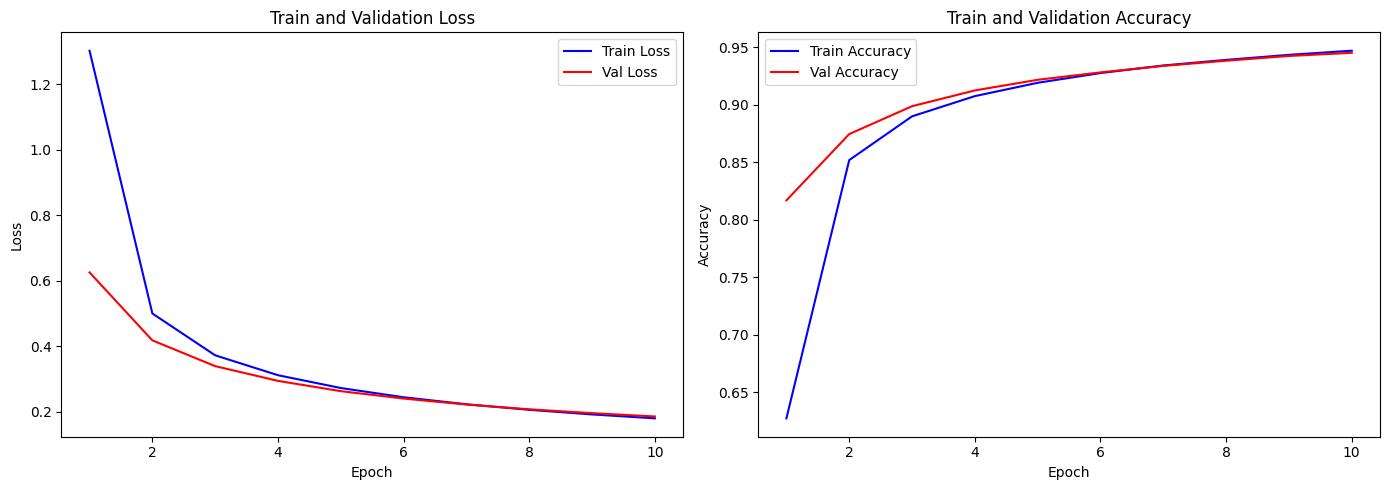

We can see that our model learns very quickly: in just the first four epochs, training loss plunges from about 1.3 down to 0.3 (and validation loss from 0.63 to 0.29), while accuracy leaps from roughly 63 % up to 91 %. After that initial burst of progress, both loss and accuracy settle into a gentle improvement, reaching around 0.18 loss and 94–95 % accuracy by epoch 10.

Notably, the validation curves run almost hand‑in‑hand with the training curves—validation accuracy even edges slightly above training—so there’s no sign of overfitting.

### Testing Loss:
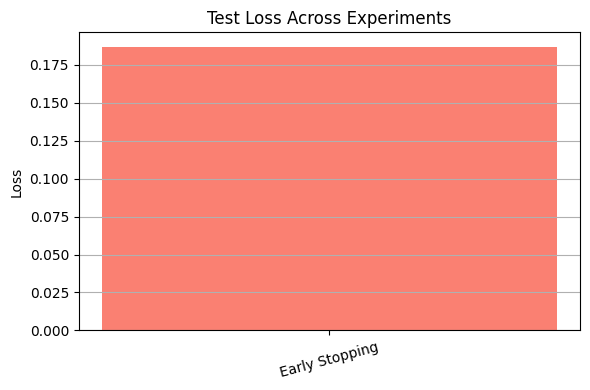

When we put our final model to the test—with early stopping in place—it delivers a test loss of about 0.185, almost exactly what we saw on the validation set. In other words, the performance on brand‑new data matches what we observed during training, which is precisely what we want to see.


### Test Accuracy:
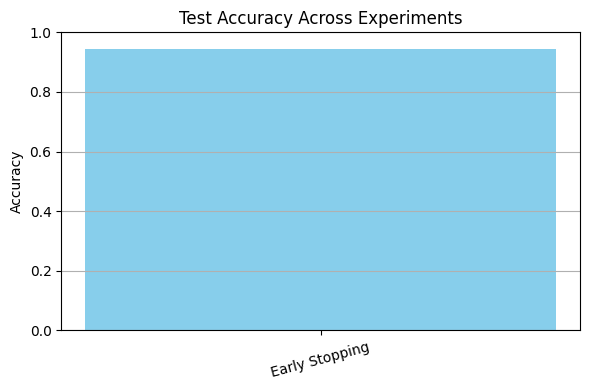

On fresh, unseen test data our early‑stopped model correctly classifies about 94.5 % of examples—essentially matching its validation accuracy. That one‑to‑one consistency shows the model has learned genuine, generalizable patterns rather than simply memorizing its training set.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

1) Dataset Link - https://drive.google.com/file/d/0Bz8a_Dbh9QhbQ2Vic1kxMmZZQ1k/view?usp=drive_link&resourcekey=0-quIUnofLp0nphL8FbmrtIQ <br>
2) https://spacy.io/ <br>
3) https://pythonspot.com/nltk-stop-words/ <br>
4) https://radimrehurek.com/gensim/models/word2vec.html <br>
5) https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html <br>
6) https://blog.paperspace.com/transformers-text-classification/

6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
|Shishir| Step 1,2,3,4 |      50 |
|Pavithran| Step 1,2,3,4 |  50 |
|   | **Total** |  100 |